In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/6"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
props_as_df = get_nao(props_as_df)
jet_pos_da = exp.jet_position_as_da()
# props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
exp_s = Experiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/4"))

da_s = exp_s.da
da_s = da_s.sel(time=da_s.time.dt.hour == 0)

ds_ = ds.sel(time=ds.time.dt.hour == 0)
ds_ = ds_.sel(time=ds_.time.dt.season == "JJA")

In [3]:
da_tp = open_da(
    "ERA5", "surf", "tp", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_T = open_da(
    "ERA5", "surf", "t2m", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_sst = open_da(
    "ERA5", "surf", "sst", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_mslp = open_da(
    "ERA5", "surf", "mslp", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_apvs = open_da(
    "ERA5", "thetalev", "apvs", "dailymean", "all", "JJA", None, None, None, None, 350, 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_cpvs = open_da(
    "ERA5", "thetalev", "cpvs", "dailymean", "all", "JJA", None, None, None, None, 350, 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_z = open_da(
    "ERA5", "plev", "z", "dailymean", "all", "JJA", None, None, None, None, 500, 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

# compare with SOM hotspells

In [4]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/4"))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    train_kwargs=dict(num_epochs=20),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [5]:
from sklearn.metrics import pairwise_distances
from xpysom_dask.diagnostics import *
dists = pairwise_distances(net.weights)
sigma = np.quantile(dists[dists > 0].flatten(), 0.05)
spells_from_som = get_persistent_spell_times_from_som(labels, dists, sigma, 40, nt_before=20, nojune=True, daily=True)
spells_from_jet_daily_stj_cs = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA", q=0.3, daily=True)
spells_from_jet_daily_edj_cs = get_persistent_jet_spells(props_as_df, "com_speed", "EDJ", "JJA", q=0.17, daily=True)
spells_from_jet_daily_stj_pe = get_persistent_jet_spells(props_as_df, "persistence", "STJ", "JJA", q=0.06, daily=True)
spells_from_jet_daily_edj_pe = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA", q=0.05, daily=True)
spells_list = {
    "SOM": spells_from_som, 
    "STJ_CS": spells_from_jet_daily_stj_cs,
    "EDJ_CS": spells_from_jet_daily_edj_cs,
    "STJ_PE": spells_from_jet_daily_stj_pe,
    "EDJ_PE": spells_from_jet_daily_edj_pe,
}
colors = [COLORS[3], COLORS[2], COLORS[1], COLORS_EXT[6], COLORS_EXT[1]]
for spell in spells_list.values():
    print(spell["spell"].max())

49
75
79
75
79


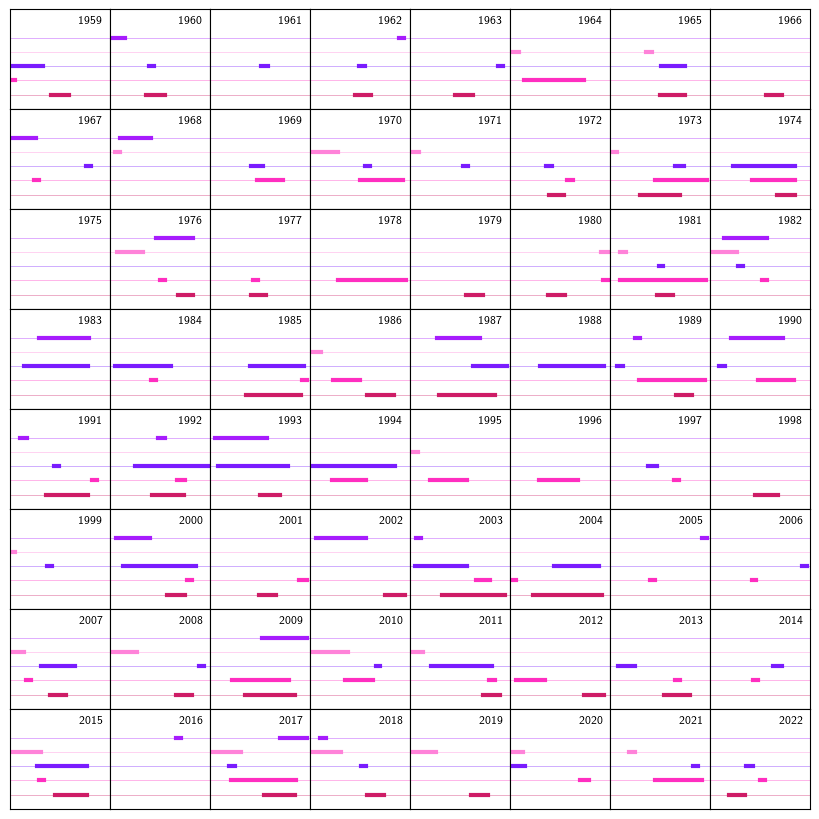

In [6]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8), gridspec_kw=dict(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1), subplot_kw=dict(xticks=[], yticks=[], xlim=[-1, 95], ylim=[-1, 6]))
axes = axes.ravel()
for ax, year in zip(axes, YEARS):
    ax.text(65, 5, f"{year}", fontsize=8)
    for j, (name_, spell) in enumerate(spells_list.items()):
        ax.plot([-1, 95], [j, j], color=colors[j], lw=.5, ls="solid", alpha=0.5)
        spell_ = spell.filter(pl.col("time").dt.year() == year)
        if len(spell_) == 0:
            continue
        x = [spell_["time"].dt.ordinal_day().first() - 152, spell_["time"].dt.ordinal_day().last() - 152]
        y = [j, j]
        ax.plot(x, y, color=colors[j], lw=3)

# Natural coordinates composites

In [10]:
def anom_around_jet(jets, da):
    varname = da.name
    jets_with_interp = gather_normal_da_jets(jets, da)
    index_columns = get_index_columns(jets_with_interp, ["spell", "relative_index", "jet ID", "time", "index", "n"])
    if "relative_index" in index_columns and "time" in index_columns:
        index_columns.remove("time")
    jets_with_interp_ds = polars_to_xarray(jets_with_interp, index_columns=index_columns)
    index_columns.remove("index")
    index_columns.remove("n")
    return jets_with_interp, jets_with_interp_ds, f"{varname}_interp"
    

def anom_around_persistent_jets(jets, da, props_as_df, metric: Literal["persistence", "com_speed"], jet: Literal["EDJ", "STJ"], season: list | str | None = None, q: float = 0.2, daily: bool = False):
    spells_from_jet = get_persistent_jet_spells(props_as_df, metric=metric, jet=jet, season=season, q=q, daily=daily)
    print(spells_from_jet["spell"].max())
    jets_during_spells = mask_from_spells_pl(spells_from_jet, jets)
    return anom_around_jet(jets_during_spells, da)


def interp_jets_to_zero_one(jets: pl.DataFrame, varnames: Sequence[str] | str):
    if isinstance(varnames, str):
        varnames = [varnames]
    index_columns = get_index_columns(jets)
    if "relative_index" in index_columns and "time" in index_columns:
        index_columns.remove("time")
    jets = jets.with_columns(norm_index=jets.group_by(index_columns, maintain_order=True).agg(pl.col("index") / pl.col("index").max())["index"].explode())
    jets = jets.group_by([*index_columns, ((pl.col("norm_index") * 100) // 1) / 100, "n"], maintain_order=True).agg([pl.col(varname).mean() for varname in varnames])
    return jets
    # return polars_to_xarray(jets, [*index_columns, "norm_index", "n"]).interpolate_na("norm_index")

In [7]:
jets_with_normal_apvs = []
for year in tqdm(all_jets_one_df["time"].dt.year().unique()):
    jets_with_normal_apvs.append(gather_normal_da_jets(all_jets_one_df.filter(pl.col("time").dt.year() == year, pl.col("time").dt.month().is_in([6, 7, 8])), da_apvs.sel(time=((da_apvs.time.dt.year.values==year) & (da_apvs.time.dt.season.values=="JJA")))))
jets_with_normal_apvs = pl.concat(jets_with_normal_apvs)

100%|██████████| 64/64 [07:27<00:00,  6.99s/it]


In [13]:
jets_with_normal_apvs_norm = interp_jets_to_zero_one(jets_with_normal_apvs, ["apvs_interp", "is_polar"])

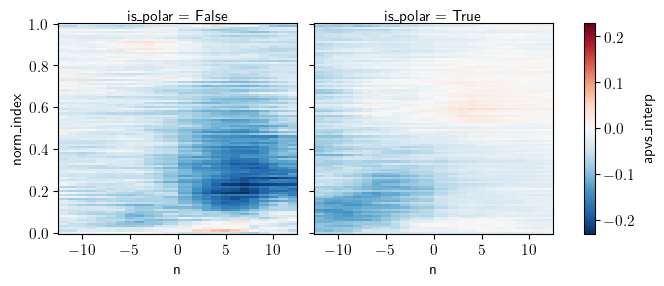

In [16]:
polars_to_xarray(jets_with_normal_apvs_norm.group_by([pl.col("is_polar") > 0.5, "norm_index", "n"], maintain_order=True).agg(pl.col("apvs_interp").mean()),  ["is_polar", "norm_index", "n"]).plot(col="is_polar")

In [17]:
jets_with_interp_ps, jets_with_interp_ds, varname = anom_around_persistent_jets(
    all_jets_one_df, da_apvs, props_as_df, "persistence", "EDJ", "JJA", q=0.05, daily=True,
)

79


KeyboardInterrupt: 

In [9]:
jets_with_interp_norm_ds = interp_jets_to_zero_one(jets_with_interp_ps, varnames=varname)

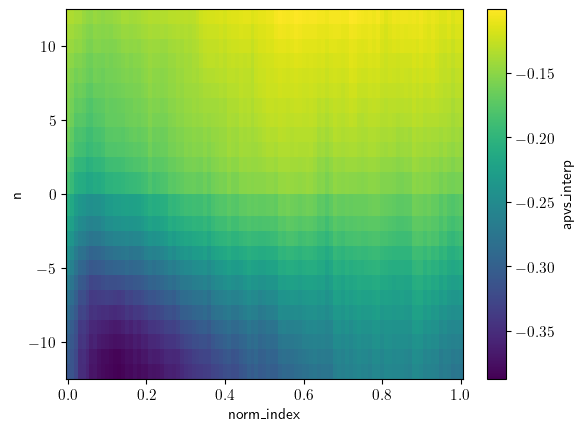

In [12]:
jets_with_interp_norm_ds.mean(["spell", "relative_index", "jet ID"]).transpose().plot()

# Relative time series

25

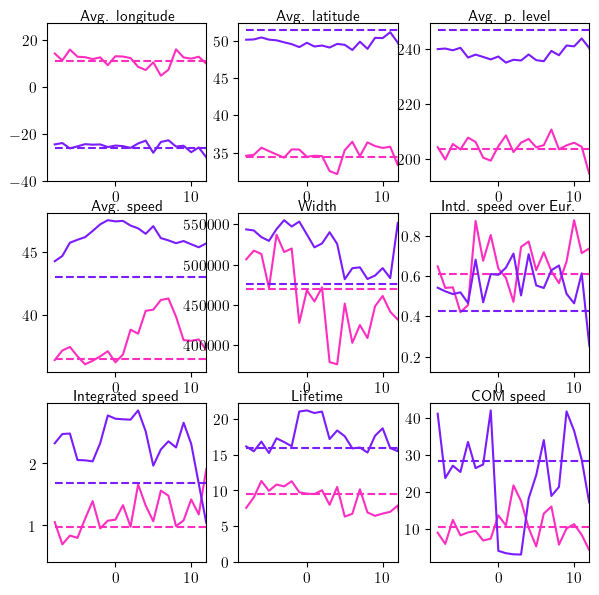

In [7]:
spells_from_jet = get_persistent_jet_spells(props_as_df, "com_speed", "EDJ", "JJA", q=0.1)
props_masked = mask_from_spells_pl(spells_from_jet, props_as_df)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j])
        mean = means[j, data_var] / factor
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    ax.set_xlim([ax.get_xlim()[0], 12])
props_masked["spell"].max()

75

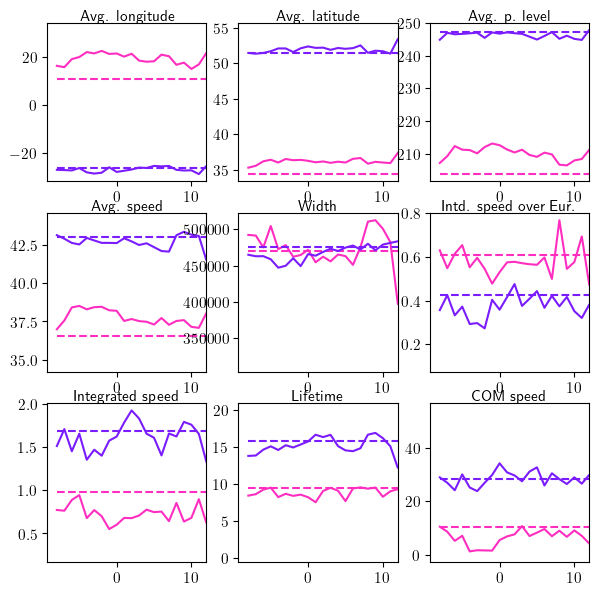

In [5]:
spells_from_jet = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA", q=0.3)
props_masked = mask_from_spells_pl(spells_from_jet, props_as_df)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j])
        mean = means[j, data_var] / factor
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    ax.set_xlim([ax.get_xlim()[0], 12])
props_masked["spell"].max()

79

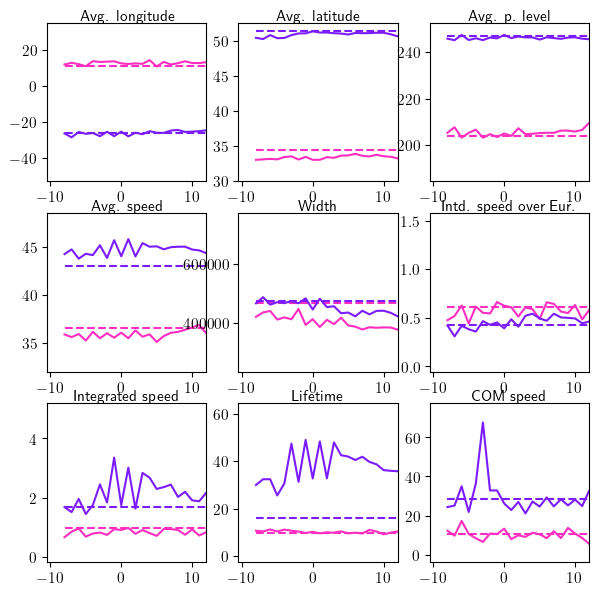

In [6]:
spells_from_jet = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA", q=0.05)
props_masked = mask_from_spells_pl(spells_from_jet, props_as_df)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j])
        mean = means[j, data_var] / factor
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    ax.set_xlim([ax.get_xlim()[0], 12])
props_masked["spell"].max()

59

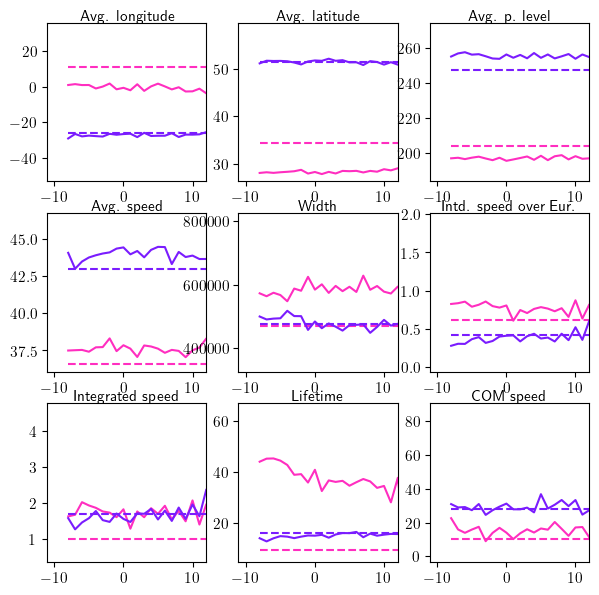

In [7]:
spells_from_jet = get_persistent_jet_spells(props_as_df, "persistence", "STJ", "JJA", q=0.05)
props_masked = mask_from_spells_pl(spells_from_jet, props_as_df)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j])
        mean = means[j, data_var] / factor
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    ax.set_xlim([ax.get_xlim()[0], 12])
props_masked["spell"].max()

# Relative anomaly time series

In [13]:
props_anom = compute_anomalies_pl(props_as_df, smooth_clim=7 * 4, normalize=True)

25

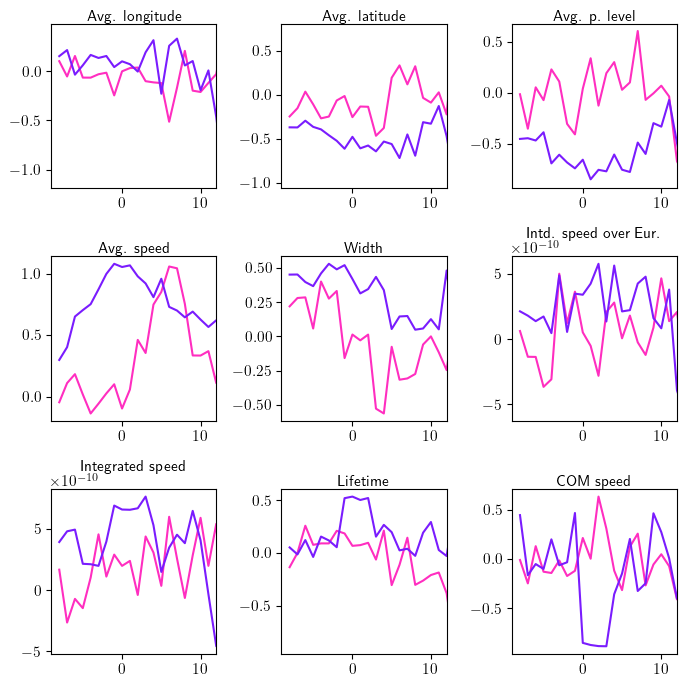

In [16]:
spells_from_jet = get_persistent_jet_spells(props_as_df, "com_speed", "EDJ", "JJA", q=0.1)
props_masked = mask_from_spells_pl(spells_from_jet, props_anom)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7), tight_layout=True)
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j])
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    ax.set_xlim([ax.get_xlim()[0], 12])
props_masked["spell"].max()

75

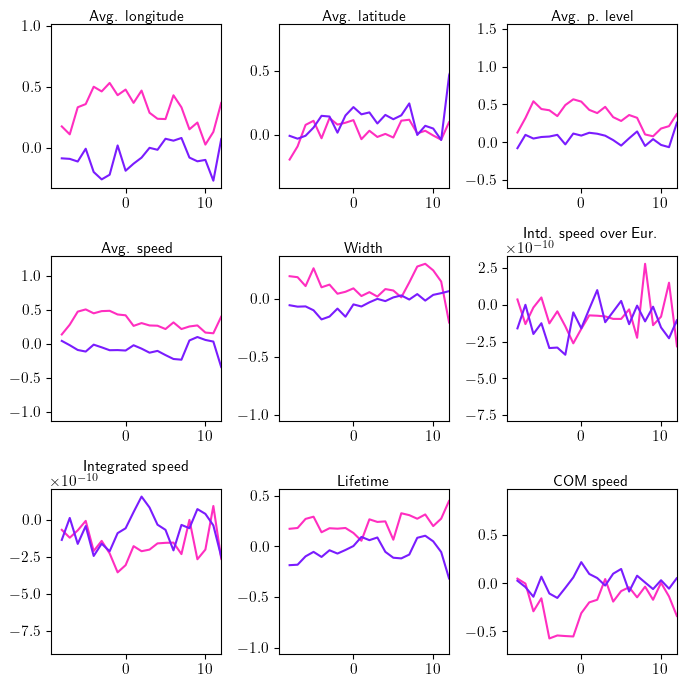

In [21]:
spells_from_jet = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA", q=0.3)
props_masked = mask_from_spells_pl(spells_from_jet, props_anom)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7), tight_layout=True)
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j])
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    ax.set_xlim([ax.get_xlim()[0], 12])
props_masked["spell"].max()

79

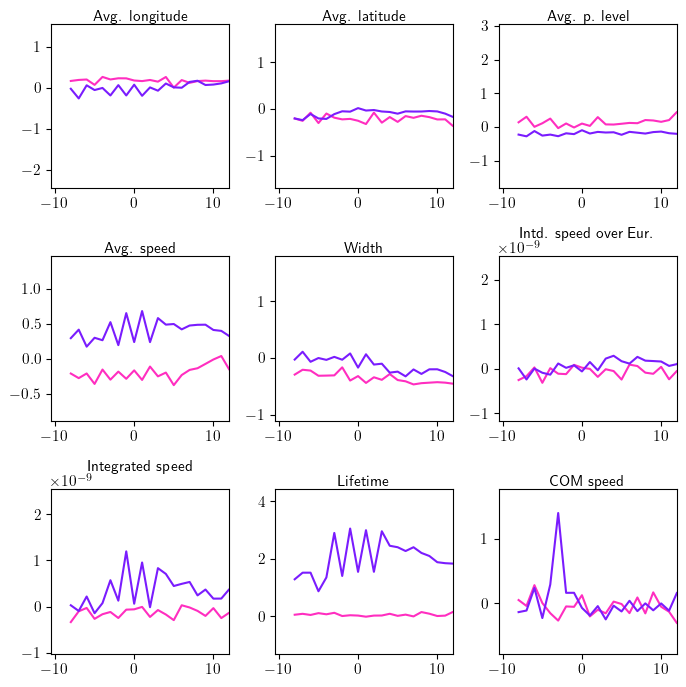

In [18]:
spells_from_jet = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA", q=0.05)
props_masked = mask_from_spells_pl(spells_from_jet, props_anom)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7), tight_layout=True)
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j])
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    ax.set_xlim([ax.get_xlim()[0], 12])
props_masked["spell"].max()

59

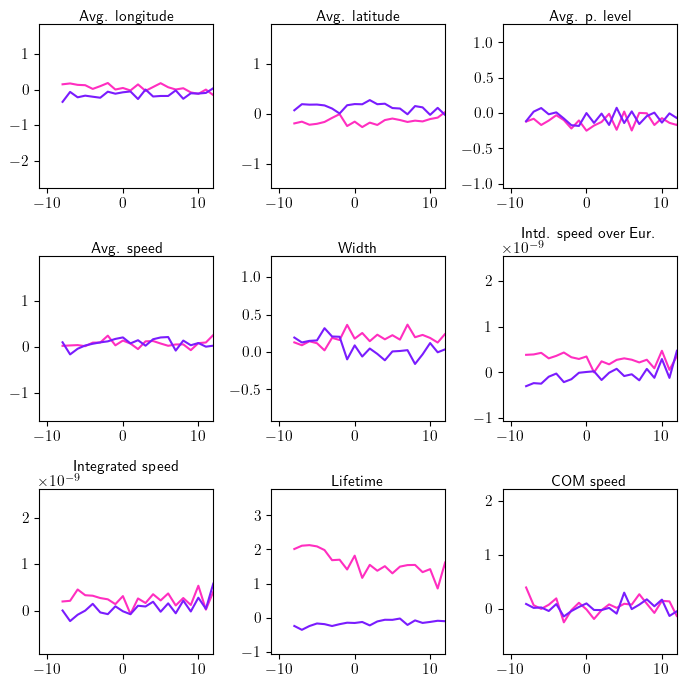

In [19]:
spells_from_jet = get_persistent_jet_spells(props_as_df, "persistence", "STJ", "JJA", q=0.05)
props_masked = mask_from_spells_pl(spells_from_jet, props_anom)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "int_over_europe", "int", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7), tight_layout=True)
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j])
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
for ax in axes:
    ax.set_xlim([ax.get_xlim()[0], 12])
props_masked["spell"].max()

# Relative time composites

14

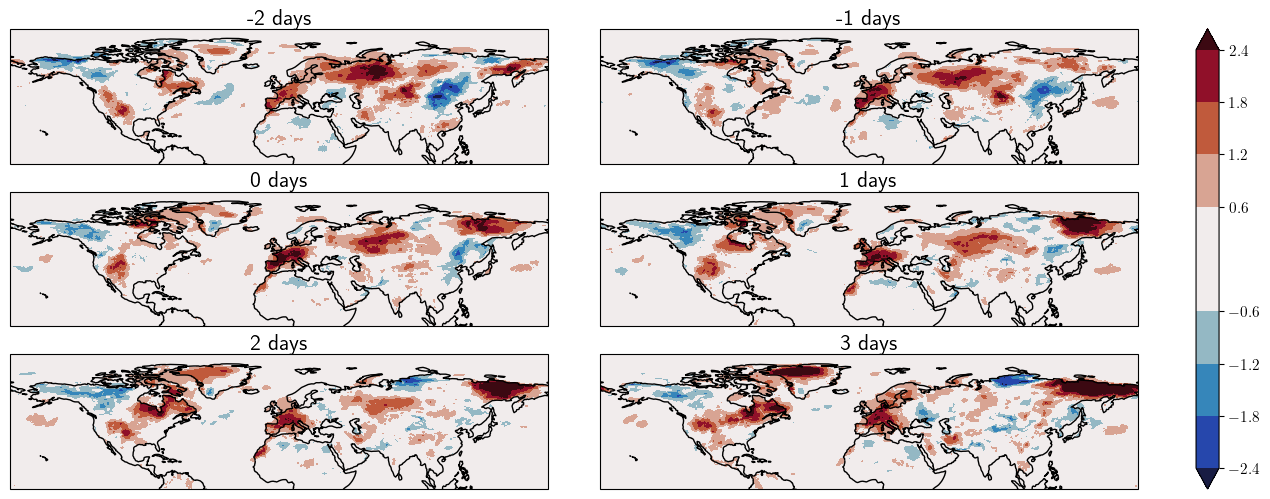

In [15]:
clu = Clusterplot(3, 2, get_region(da_T))
da_T = compute(da_T.sel(time=da_T.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA", q=0.23, daily=True)
T_masked = mask_from_spells_pl(spells_from_jet_daily, da_T)
_ = clu.add_contourf(
    T_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5]),
    levels=7,
    cmap=colormaps.balance,
    titles=T_masked.relative_time[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)
T_masked.spell.shape[0]

13

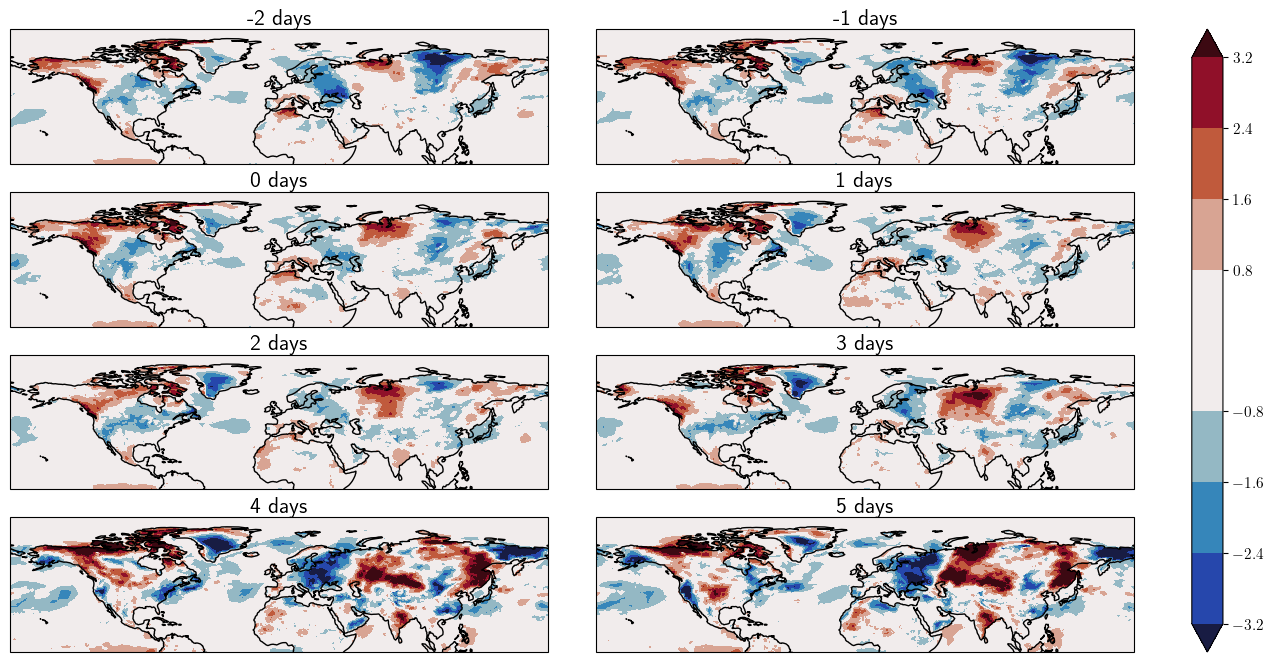

In [16]:
clu = Clusterplot(4, 2, get_region(da_T))
da_T = compute(da_T.sel(time=da_T.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA", q=0.01, daily=True)
T_masked = mask_from_spells_pl(spells_from_jet_daily, da_T)
_ = clu.add_contourf(
    T_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    levels=7,
    cmap=colormaps.balance,
    titles=T_masked.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)
T_masked.spell.shape[0]

14

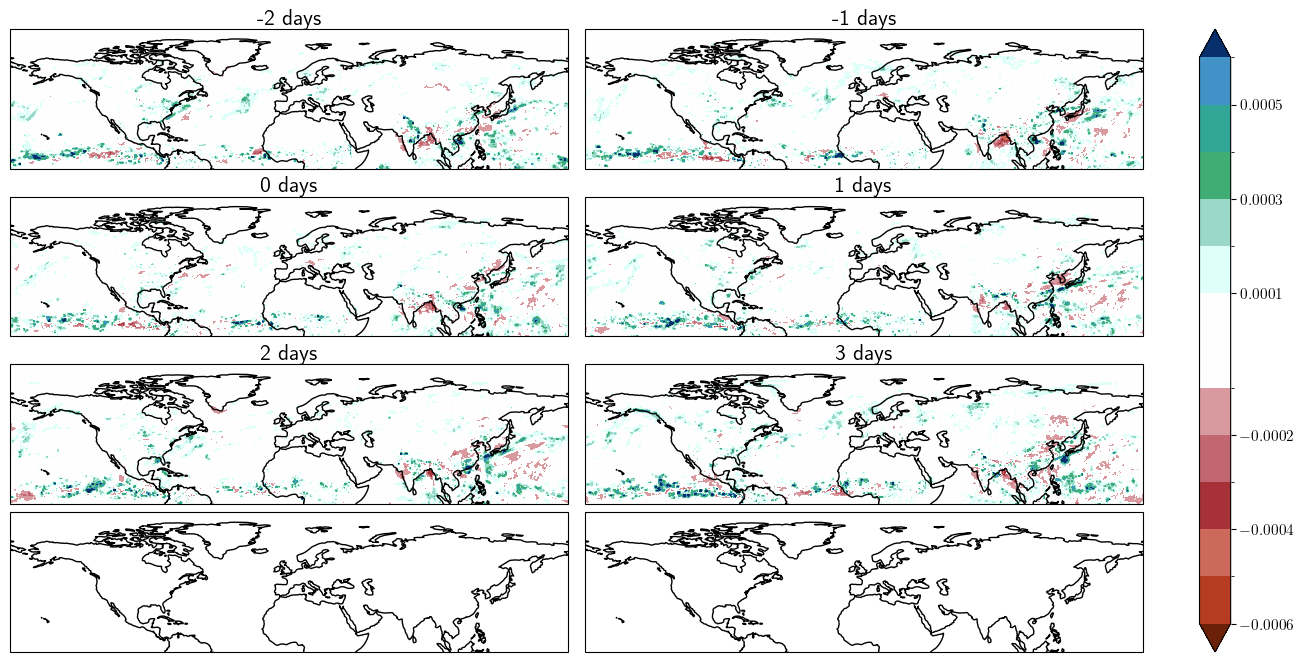

In [17]:
clu = Clusterplot(4, 2, get_region(da_tp))
da_tp = compute(da_tp.sel(time=da_tp.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA", q=0.23, daily=True)
tp_masked = mask_from_spells_pl(spells_from_jet_daily, da_tp)
_ = clu.add_contourf(
    tp_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5]),
    levels=13,
    cmap=colormaps.precip4_diff_19lev,
    titles=tp_masked.relative_time[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
    transparify=0,
    q=0.999,
)
tp_masked.spell.shape[0]

13

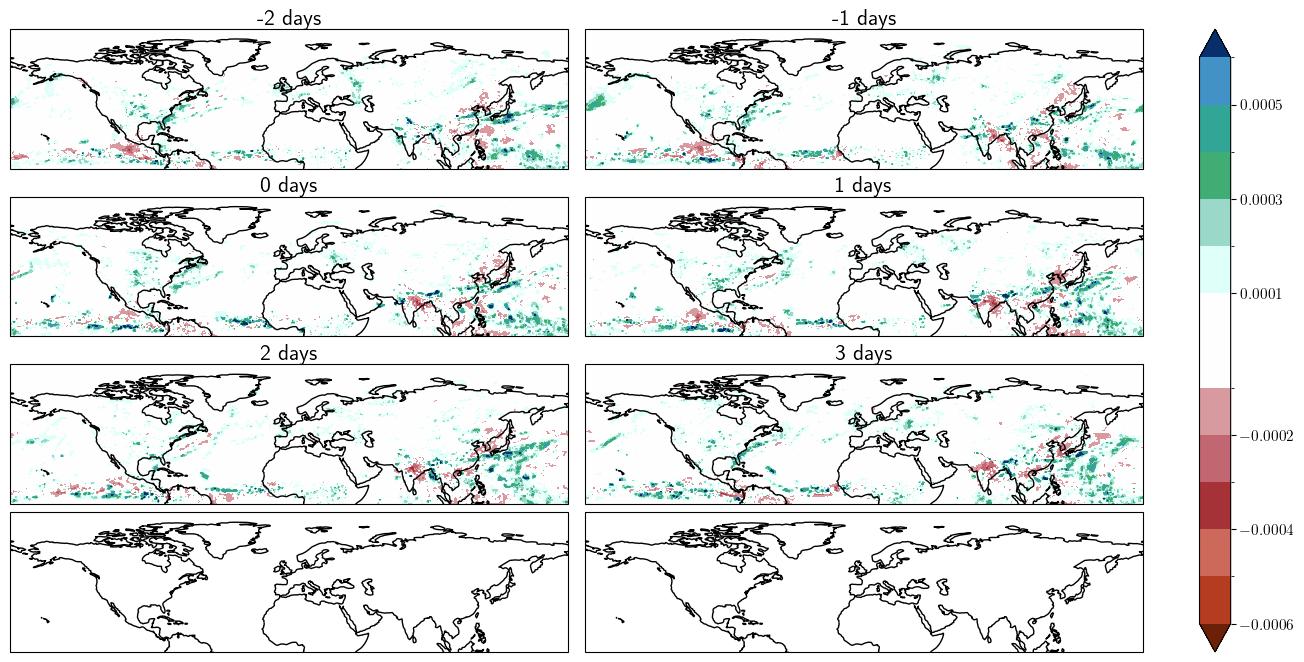

In [18]:
clu = Clusterplot(4, 2, get_region(da_tp))
da_tp = compute(da_tp.sel(time=da_tp.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA", q=0.01, daily=True)
tp_masked = mask_from_spells_pl(spells_from_jet_daily, da_tp)
_ = clu.add_contourf(
    tp_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5]),
    levels=13,
    cmap=colormaps.precip4_diff_19lev,
    titles=tp_masked.relative_time[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
    transparify=0,
    q=0.999,
)
tp_masked.spell.shape[0]

14

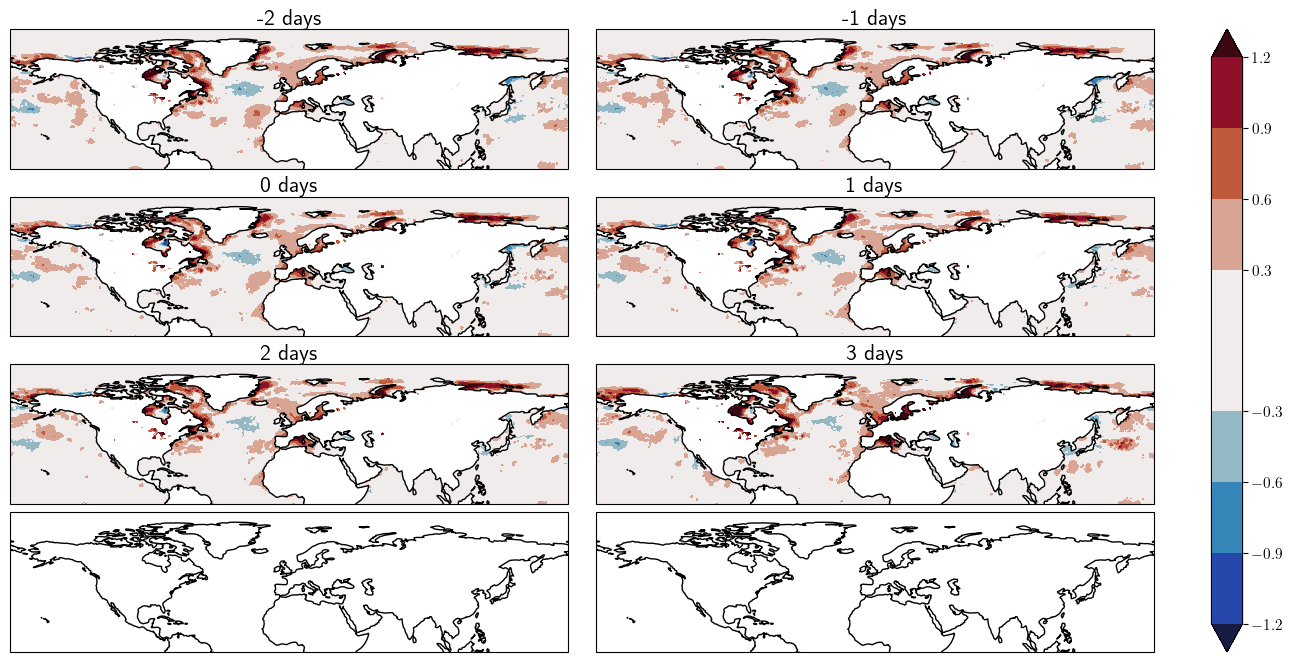

In [19]:
clu = Clusterplot(4, 2, get_region(da_sst))
da_sst = compute(da_sst.sel(time=da_sst.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA", q=0.23, daily=True)
sst_masked = mask_from_spells_pl(spells_from_jet_daily, da_sst)
_ = clu.add_contourf(
    sst_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5]),
    levels=7,
    cmap=colormaps.balance,
    titles=sst_masked.relative_time[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)
sst_masked.spell.shape[0]

13

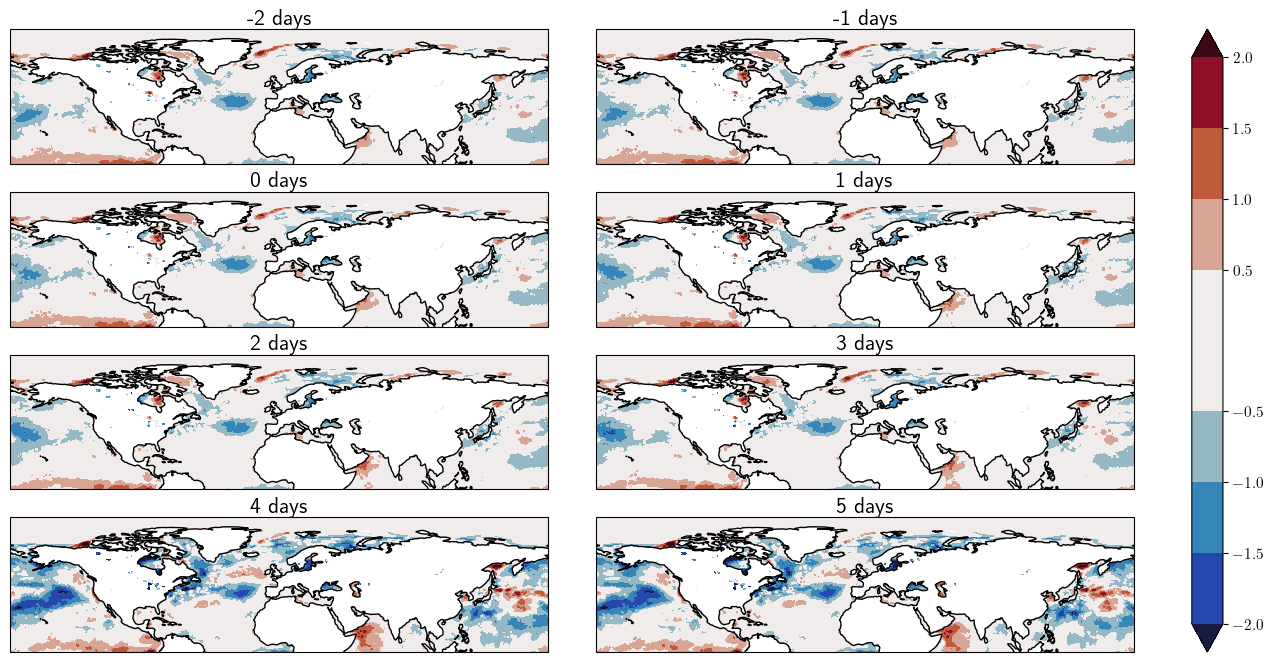

In [20]:
clu = Clusterplot(4, 2, get_region(da_sst))
da_sst = compute(da_sst.sel(time=da_sst.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA", q=0.01, daily=True)
sst_masked = mask_from_spells_pl(spells_from_jet_daily, da_sst)
_ = clu.add_contourf(
    sst_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    levels=7,
    cmap=colormaps.balance,
    titles=sst_masked.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)
sst_masked.spell.shape[0]

14

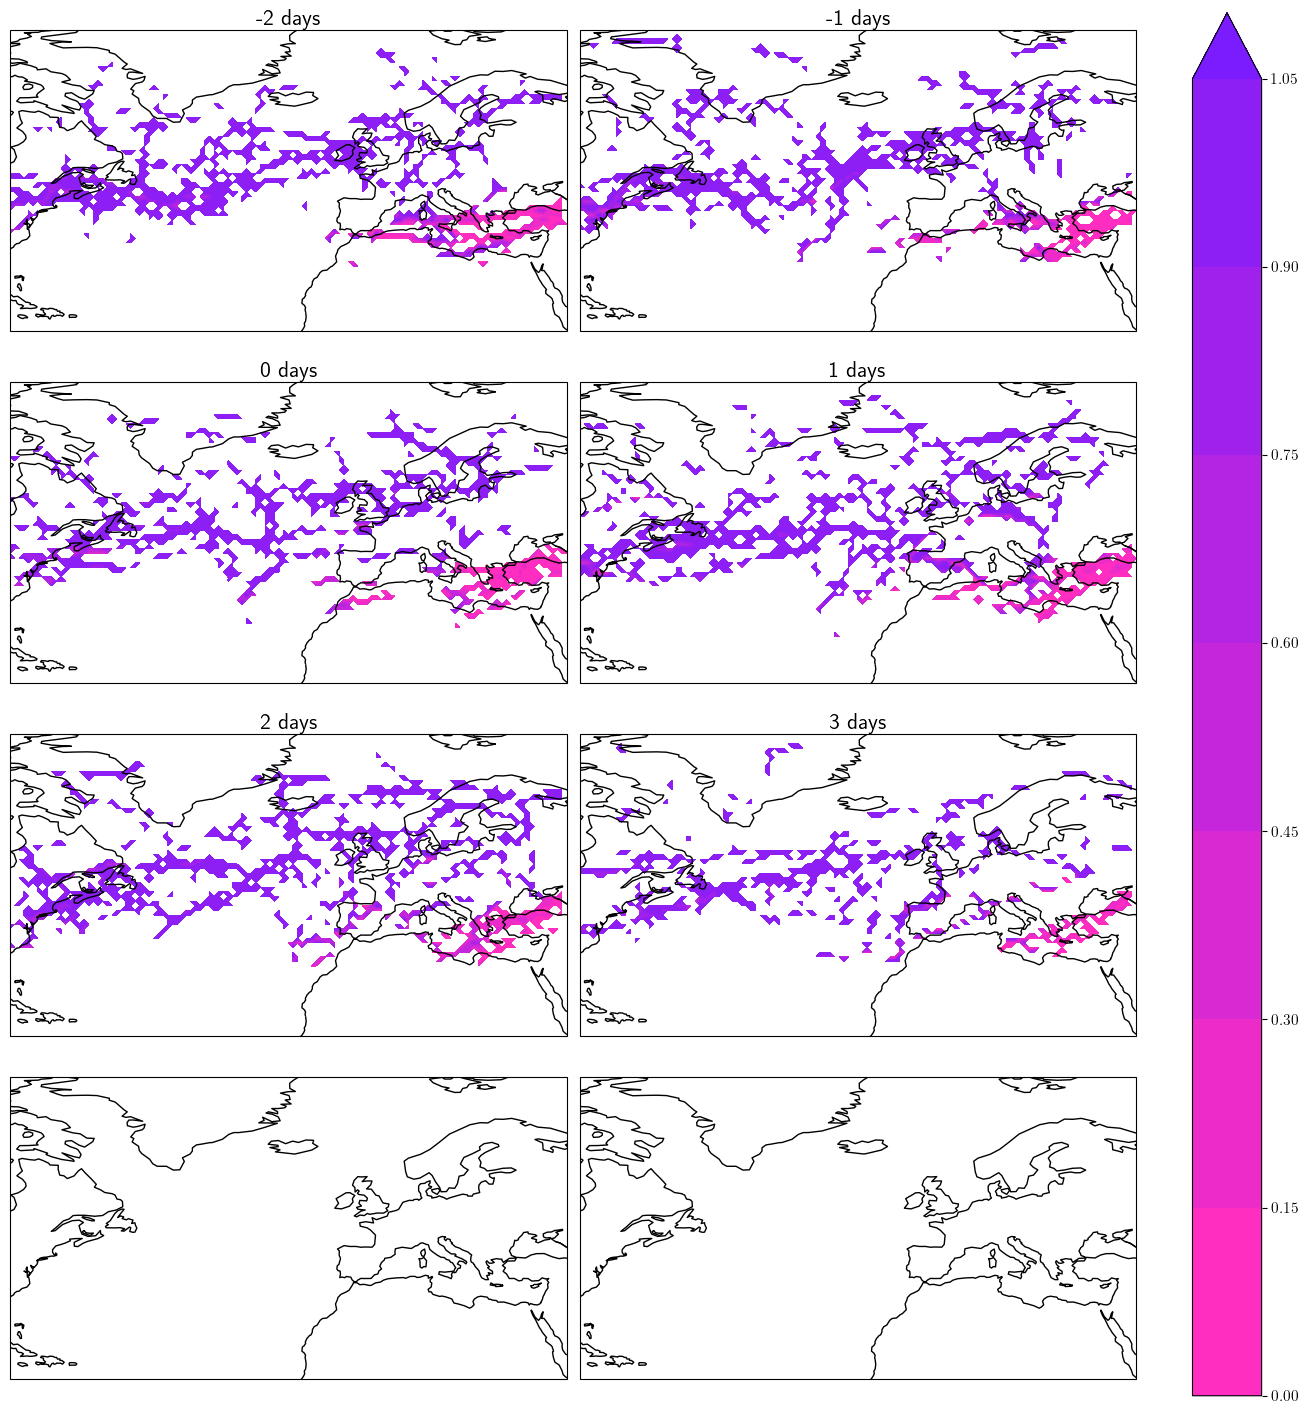

In [21]:
clu = Clusterplot(4, 2, get_region(jet_pos_da))
jet_pos_da = compute(jet_pos_da.sel(time=jet_pos_da.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA", q=0.23, daily=True)
jp_masked = mask_from_spells_pl(spells_from_jet_daily, jet_pos_da)
_ = clu.add_contourf(
    jp_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5]),
    levels=7,
    cmap=PINKPURPLE,
    titles=jp_masked.relative_time[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)
jp_masked.spell.shape[0]

13

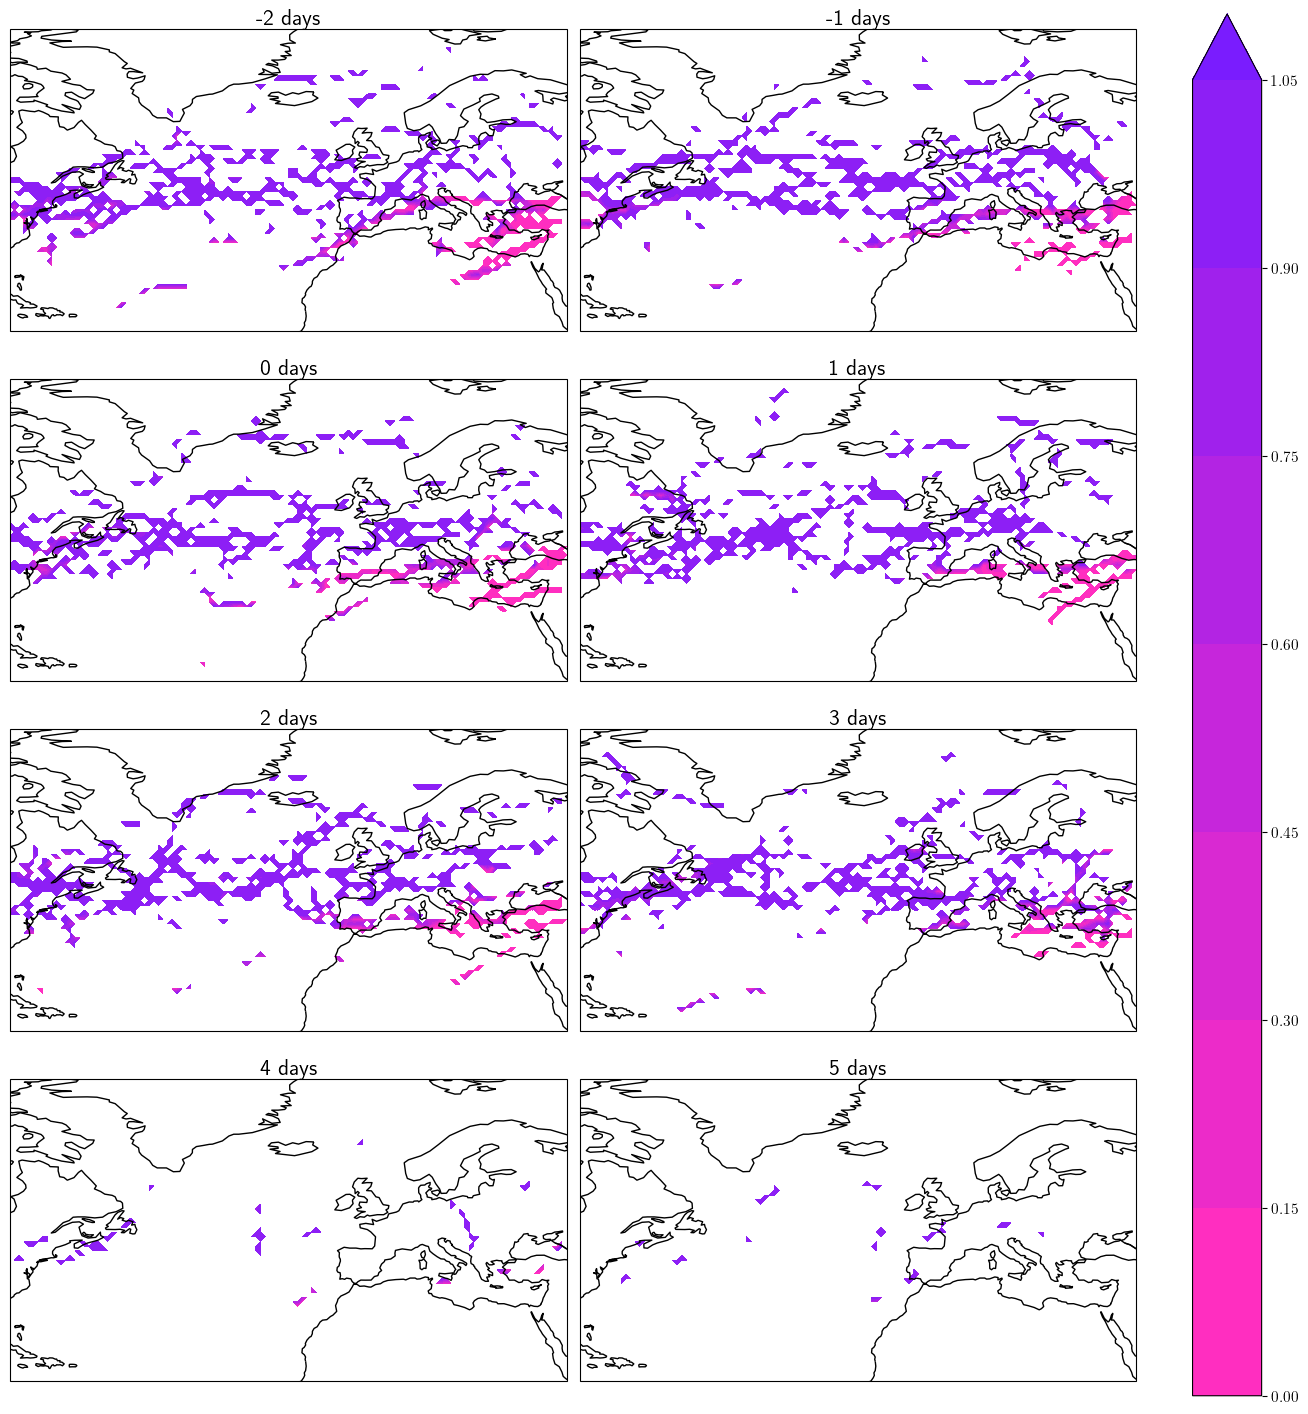

In [22]:
clu = Clusterplot(4, 2, get_region(jet_pos_da))
jet_pos_da = compute(jet_pos_da.sel(time=jet_pos_da.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA", q=0.01, daily=True)
jp_masked = mask_from_spells_pl(spells_from_jet_daily, jet_pos_da)
_ = clu.add_contourf(
    jp_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    levels=7,
    cmap=PINKPURPLE,
    titles=jp_masked.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)
jp_masked.spell.shape[0]

14

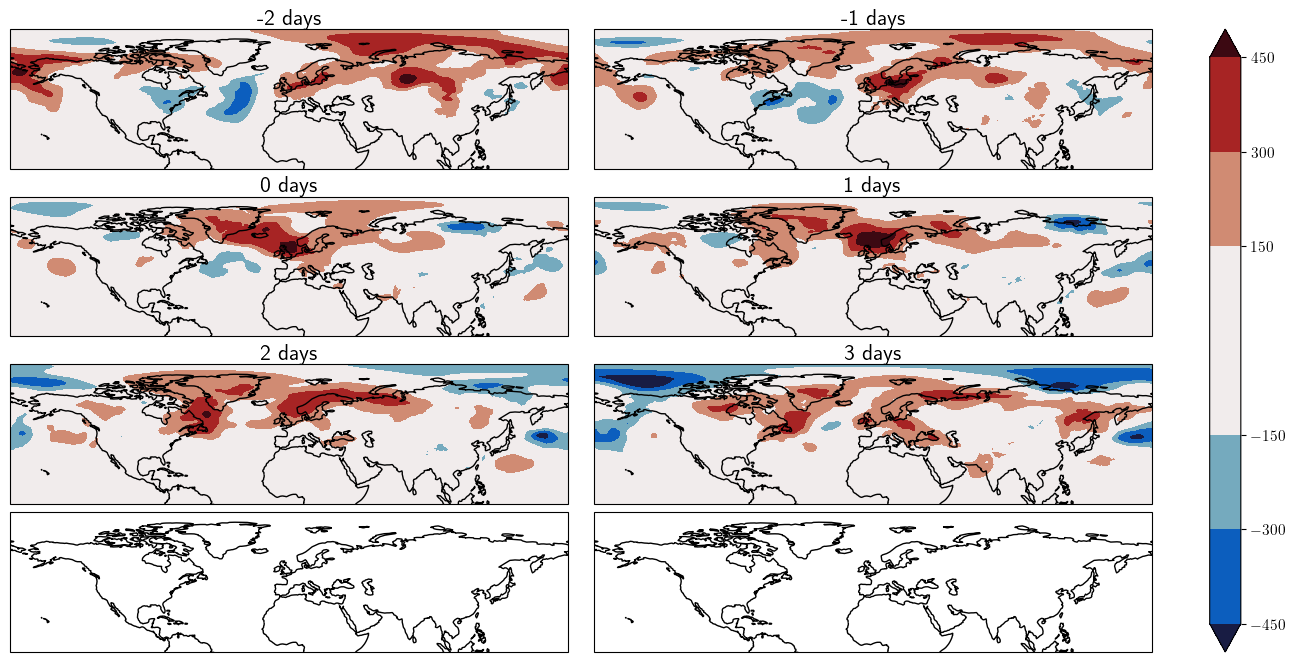

In [23]:
clu = Clusterplot(4, 2, get_region(da_mslp))
da_mslp = compute(da_mslp.sel(time=da_mslp.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA", q=0.23, daily=True)
mslp_masked = mask_from_spells_pl(spells_from_jet_daily, da_mslp)
_ = clu.add_contourf(
    mslp_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5]),
    levels=7,
    cmap=colormaps.balance,
    titles=mslp_masked.relative_time[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)
mslp_masked.spell.shape[0]

13

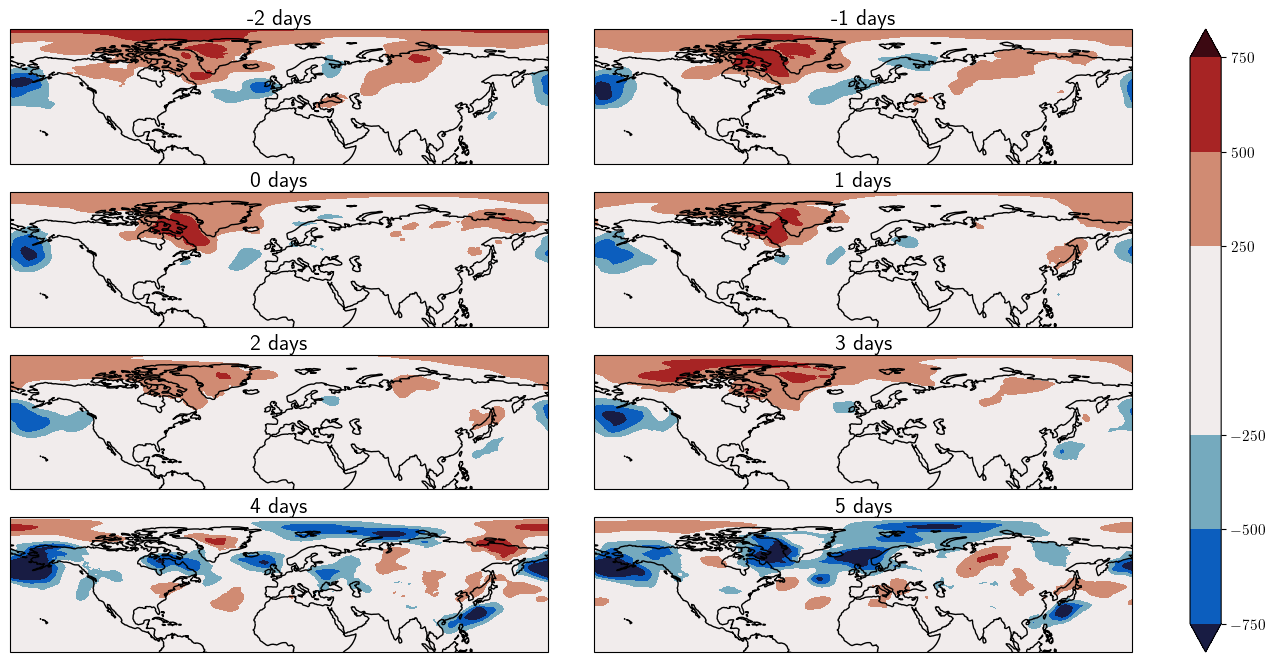

In [24]:
clu = Clusterplot(4, 2, get_region(da_mslp))
da_mslp = compute(da_mslp.sel(time=da_mslp.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA", q=0.01, daily=True)
mslp_masked = mask_from_spells_pl(spells_from_jet_daily, da_mslp)
_ = clu.add_contourf(
    mslp_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    levels=7,
    cmap=colormaps.balance,
    titles=mslp_masked.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)
mslp_masked.spell.shape[0]

14

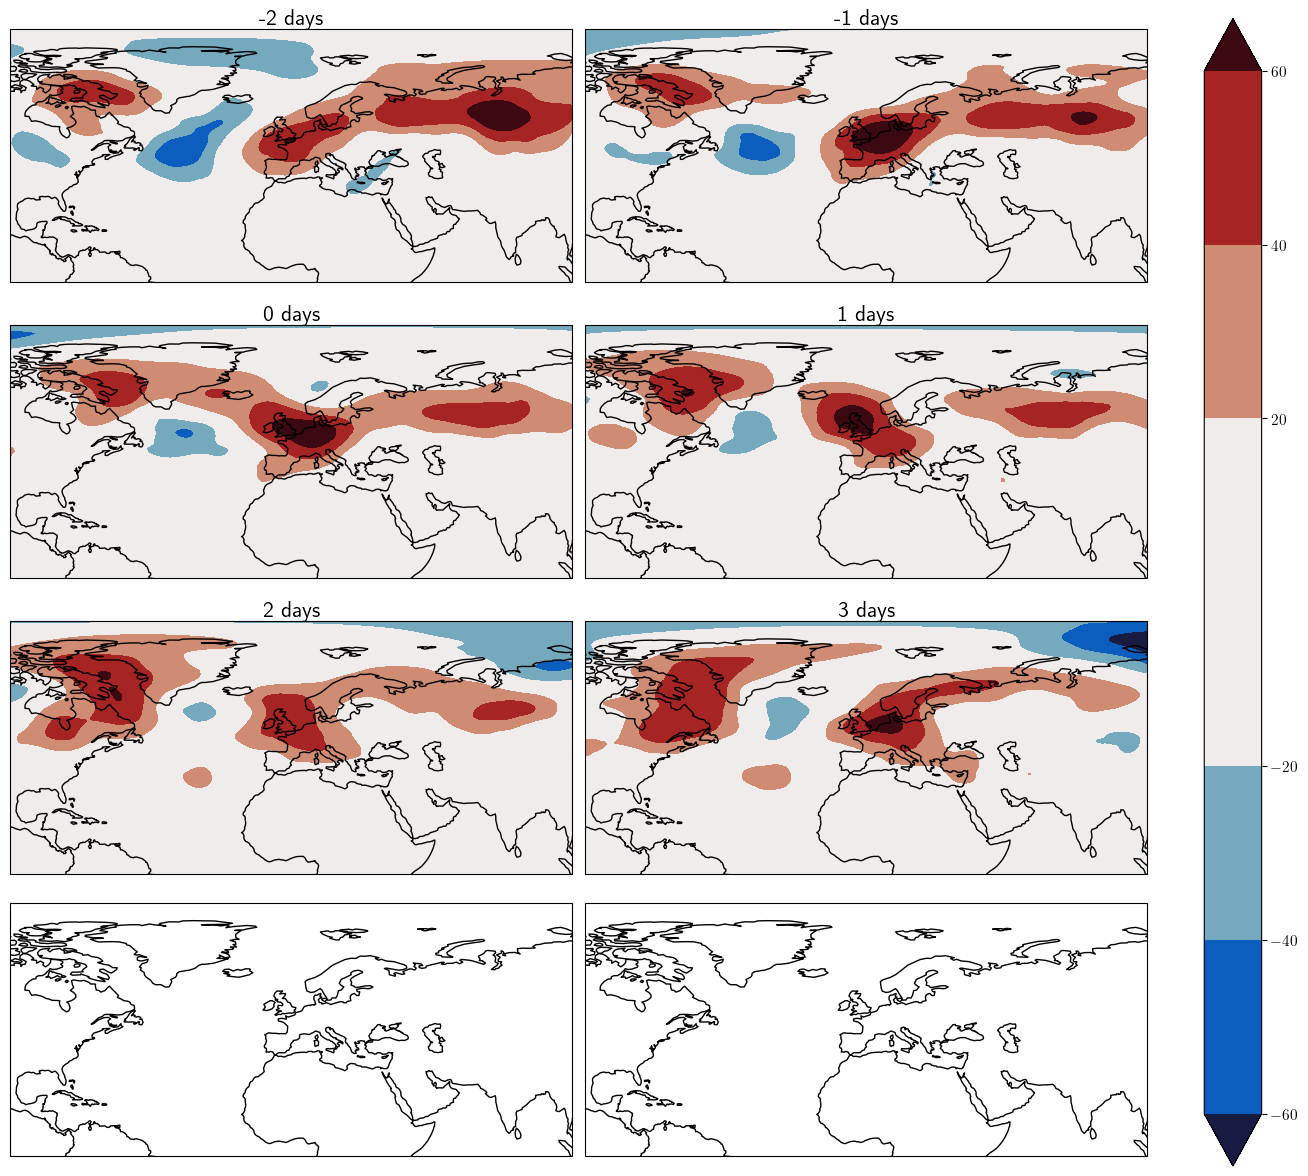

In [25]:
clu = Clusterplot(4, 2, get_region(da_z))
da_z = compute(da_z.sel(time=da_z.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA", q=0.23, daily=True)
z_masked = mask_from_spells_pl(spells_from_jet_daily, da_z)
_ = clu.add_contourf(
    z_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5])  / 9.8,
    levels=7,
    cmap=colormaps.balance,
    titles=z_masked.relative_time[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)
z_masked.spell.shape[0]

13

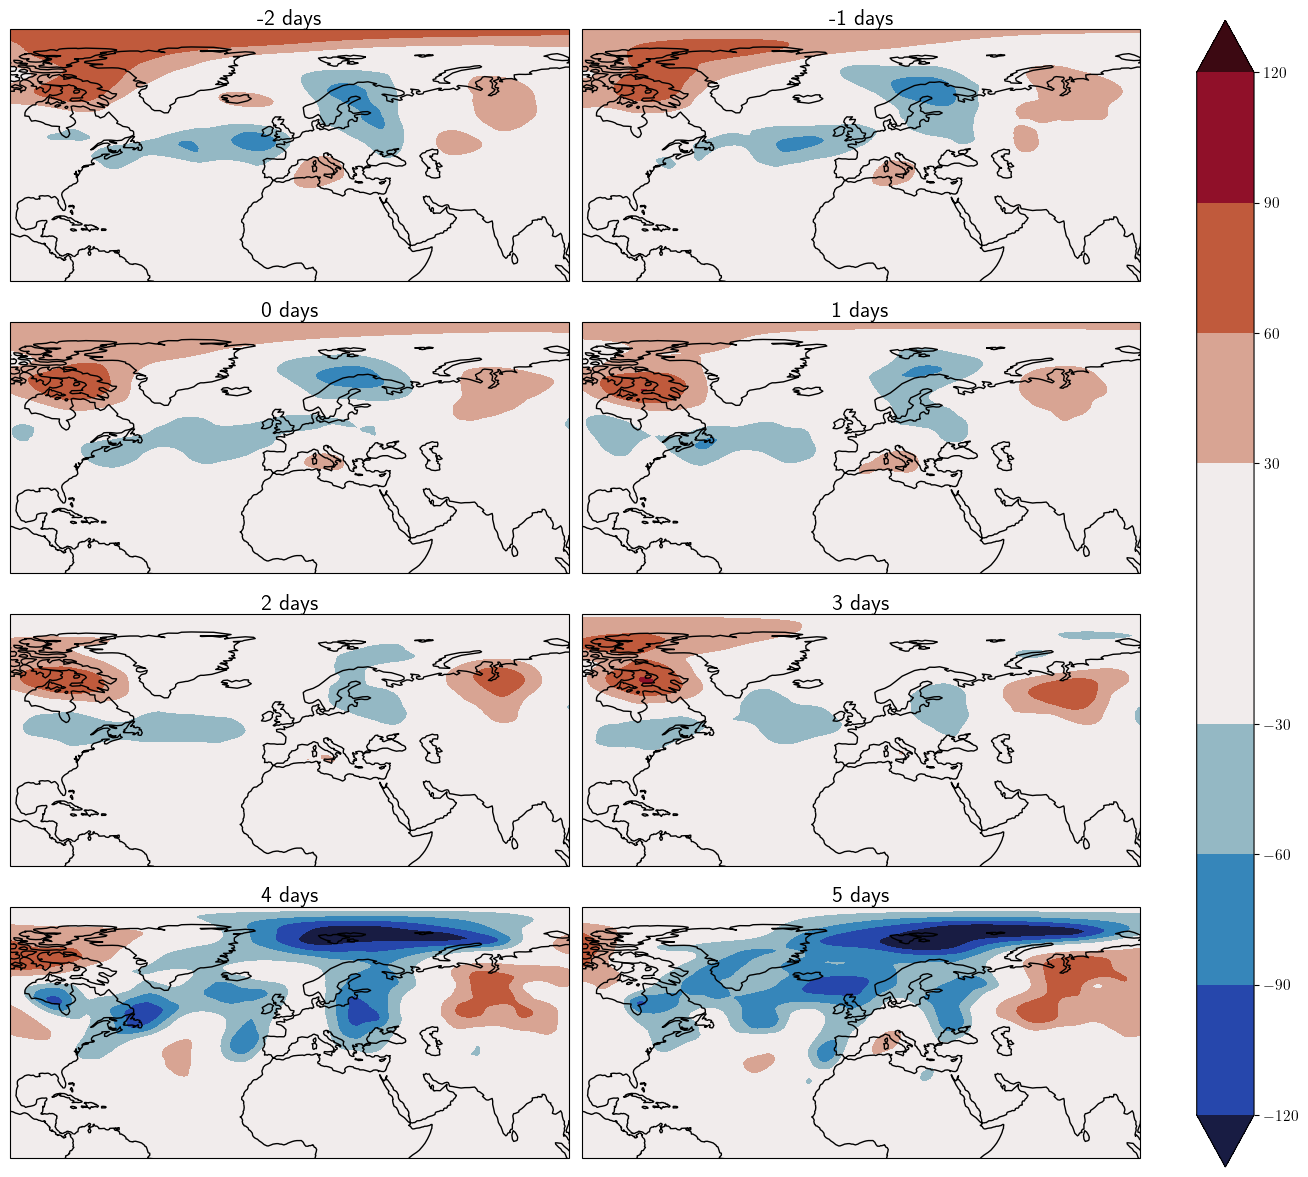

In [26]:
clu = Clusterplot(4, 2, get_region(da_z))
da_z = compute(da_z.sel(time=da_z.time.dt.season == "JJA"))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA", q=0.01, daily=True)
z_masked = mask_from_spells_pl(spells_from_jet_daily, da_z)
_ = clu.add_contourf(
    z_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]) / 9.8,
    levels=7,
    cmap=colormaps.balance,
    titles=z_masked.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)
z_masked.spell.shape[0]

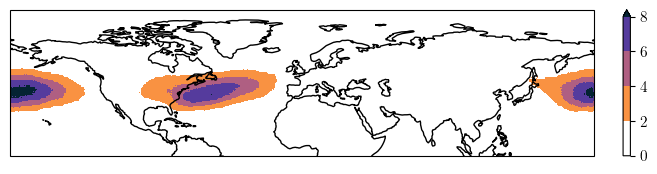

In [27]:
clu = Clusterplot(1, 1, get_region(da_apvs))
_ = clu.add_contourf([compute(np.abs(da_apvs).mean("time"))], cmap=colormaps.thermal_r, transparify=1)

14

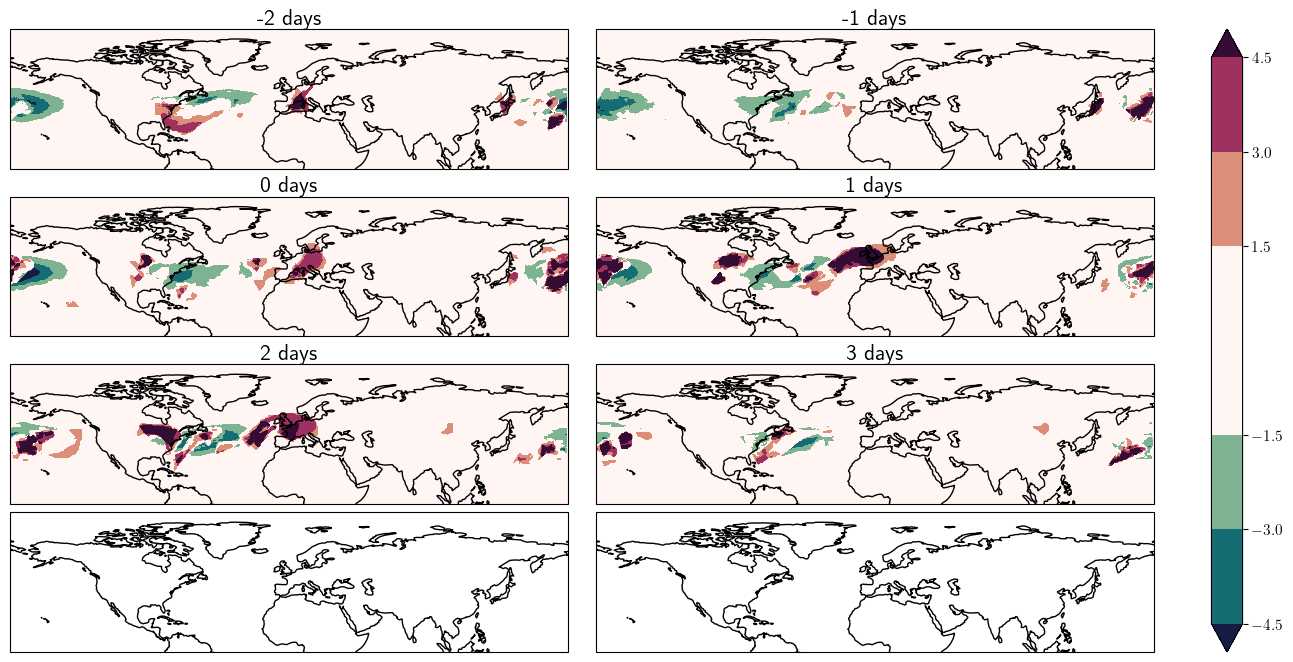

In [28]:
clu = Clusterplot(4, 2, get_region(da_apvs))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA", q=0.23, daily=True)
apvs_masked = mask_from_spells_pl(spells_from_jet_daily, da_apvs)
_ = clu.add_contourf(
    apvs_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5]),
    levels=7,
    cmap=colormaps.curl,
    titles=apvs_masked.relative_time[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)
apvs_masked.spell.shape[0]

13

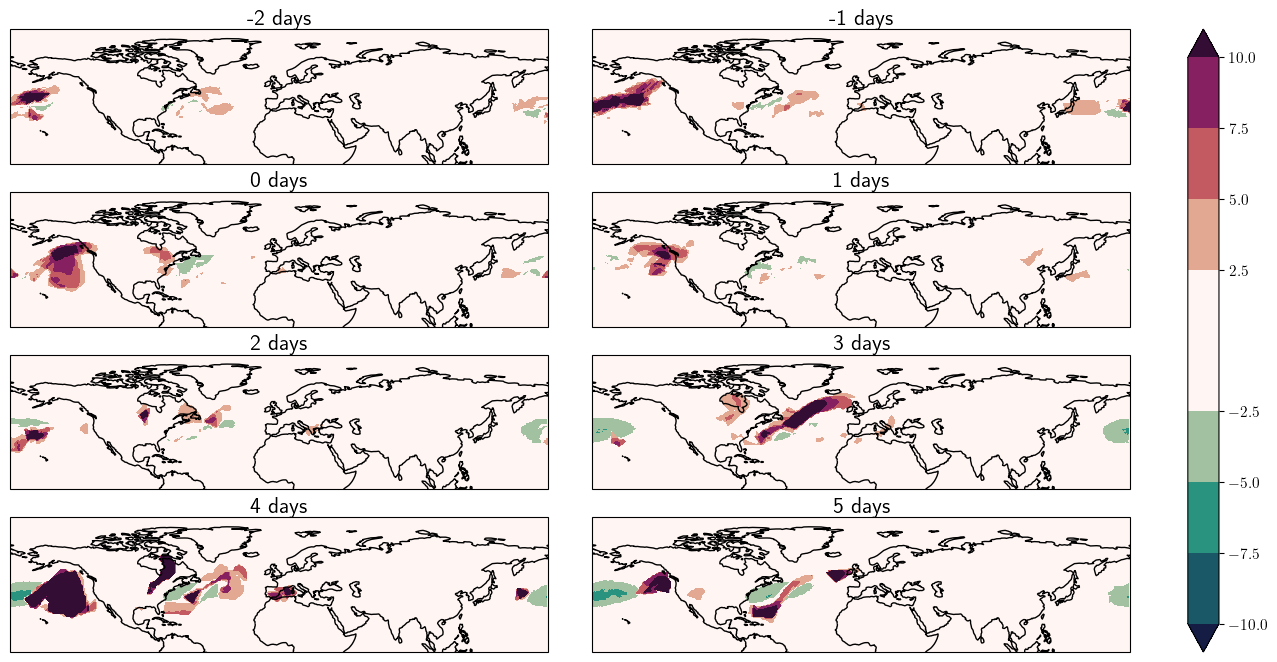

In [29]:
clu = Clusterplot(4, 2, get_region(da_apvs))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA", q=0.01, daily=True)
apvs_masked = mask_from_spells_pl(spells_from_jet_daily, da_apvs)
_ = clu.add_contourf(
    apvs_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    levels=7,
    cmap=colormaps.curl,
    titles=apvs_masked.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)
apvs_masked.spell.shape[0]

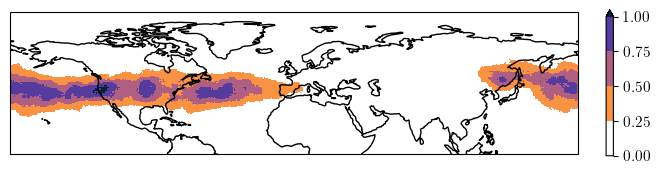

In [30]:
clu = Clusterplot(1, 1, get_region(da_cpvs))
_ = clu.add_contourf([compute(np.abs(da_cpvs).mean("time"))], cmap=colormaps.thermal_r, transparify=1)

14

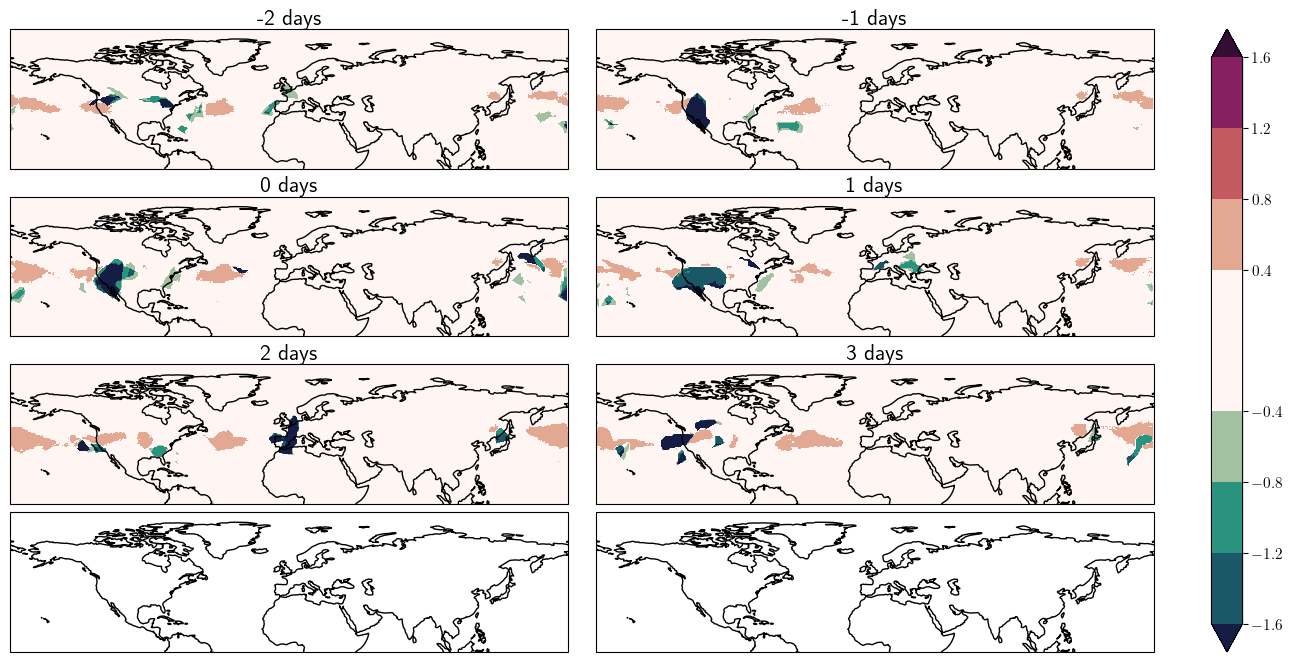

In [31]:
clu = Clusterplot(4, 2, get_region(da_cpvs))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA", q=0.23, daily=True)
cpvs_masked = mask_from_spells_pl(spells_from_jet_daily, da_cpvs)
_ = clu.add_contourf(
    cpvs_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5]),
    levels=7,
    cmap=colormaps.curl,
    titles=cpvs_masked.relative_time[[0, 1, 2, 3, 4, 5]].values.astype("timedelta64[D]"),
)
cpvs_masked.spell.shape[0]

13

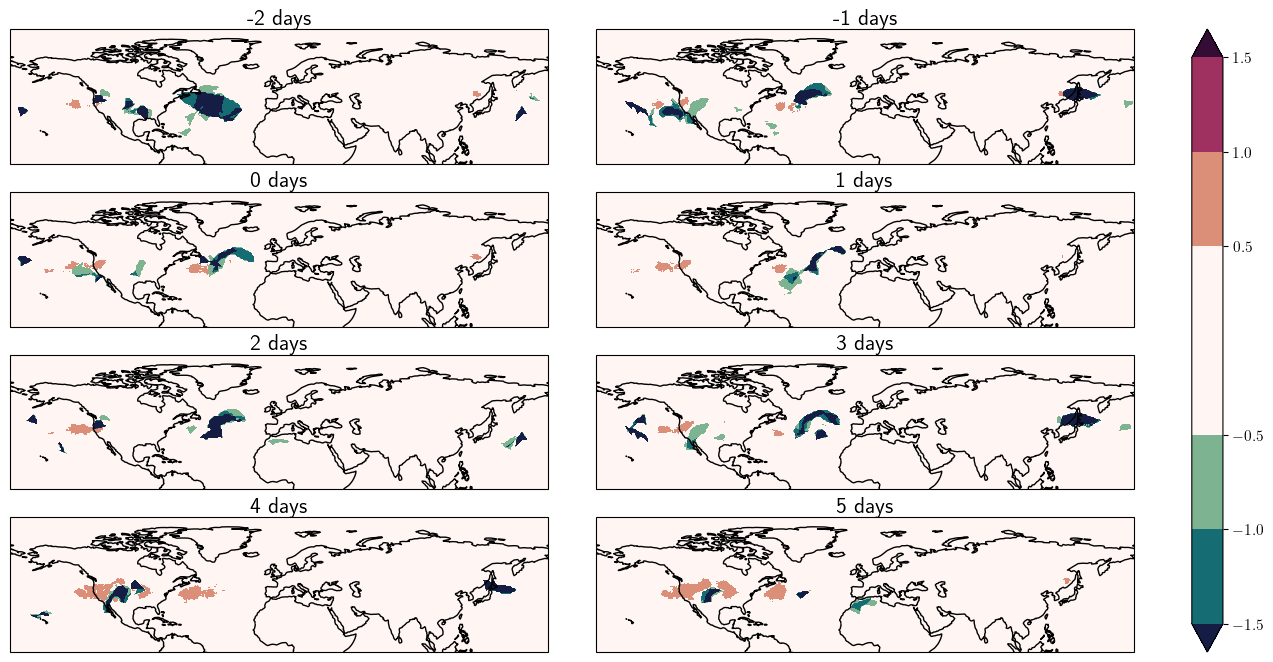

In [32]:
clu = Clusterplot(4, 2, get_region(da_cpvs))
spells_from_jet_daily = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA", q=0.01, daily=True)
cpvs_masked = mask_from_spells_pl(spells_from_jet_daily, da_cpvs)
_ = clu.add_contourf(
    cpvs_masked.mean("spell").isel(relative_index=[0, 1, 2, 3, 4, 5, 6, 7]),
    levels=7,
    cmap=colormaps.curl,
    titles=cpvs_masked.relative_time[[0, 1, 2, 3, 4, 5, 6, 7]].values.astype("timedelta64[D]"),
)
cpvs_masked.spell.shape[0]